# Rodrigo Barraza's Inscriptions: Blip 2 Mass Captioning
Large RAM and VRAM is required to load the larger models. RAM should be at least 24-32GB with 64GB being optimal. VRAM should be at least 16GB or more.

In [2]:
# !pip3 install transformers
# !pip install pillow
# !pip install requests
# !pip install validators
# !pip install accelerate

In [3]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoTokenizer, Blip2Model
import torch
import sys
import validators

import os
import re
from pathlib import Path
from collections import OrderedDict
from IPython.display import clear_output
from PIL import Image


# from lavis.models import load_model_and_preprocess

/home/rodrigo/miniconda3/envs/blip22/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Salesforce/blip2-opt-2.7b
# Salesforce/blip2-opt-2.7b-coco
# Salesforce/blip2-opt-6.7b
# Salesforce/blip2-opt-6.7b-coco
# Salesforce/blip2-flan-t5-xl
# Salesforce/blip2-flan-t5-xl-coco
# /Salesforce/blip2-flan-t5-xxl

tokenizer = AutoTokenizer.from_pretrained(
    "Salesforce/blip2-opt-6.7b-coco",
    add_prefix_space=True) # Required to use bad_words_ids
processor = Blip2Processor.from_pretrained(
    "Salesforce/blip2-opt-6.7b-coco")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-6.7b-coco",
    device_map='auto',
    # load_in_8bit=True)
    torch_dtype=torch.float16)

Loading checkpoint shards: 100%|██████████| 4/4 [00:25<00:00,  6.31s/it]


a painting of a man with wings on his back, fantasy, oil
Recaptioned Images:  0
Processed images: 1/1
Remaining images: 0 ✅


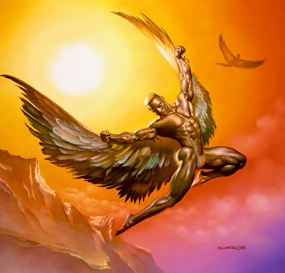

In [10]:
###############################################################################
# Start of Options

imagesDirectory = "/mnt/d/fixes/repe"
useFolderNamesAsTokens = True  # Append the folder names to the beginning of the caption
overwriteExistingCaptions = True  # Overwrite existing captions
tokensStartOrEnd = 'start'  # end or start
appendStyles = True

# PRINT OPTIONS
showCurrentImage = True
showCaption = True
showRecaptionedImages = True
showProcessedImages = True
showRemainingImages = True
clearOutput = True

# PREPROCESSOR SETTINGS
skipSpecialTokens = True

# MODEL GENERATION SETTINGS
useNucleusSampling = False
numberOfBeams = 3  # The number of beams to use for beam search
lengthPenalty = 1
minTokenLength = 5  # The amount of minimum tokens to generate
maxTokenLength = 72  # The maximum amount of tokens to generate
repetitionPenalty = 1
topP = 0.9
temperature = 1.0

# TOKENIZER SETTINGS
# enableForceWords = False
# forceWordsList = ["water"]
# removeBadWords = False
# badWordsList = ["teddy bear"]
# padding = True
# add_special_tokens = False


# prompt = "Describe the style in 1 word. Answer:"
prompt = None

# End of Options
###############################################################################

forceWordsIds = None
badWordsIds = None
primaryCaptionTokenLength = 0

# Count the total number of images in the directory and subdirectories
totalImages = 0
for dirpath, dirnames, filenames in os.walk(imagesDirectory):
    totalImages += sum([filename.lower().endswith((".jpg", ".png", ".jpeg", ".webp", "gif")) for filename in filenames])
processedImages = 0
recaptionedImages = 0

def generateCaption(rawImage, beams=numberOfBeams):
    global forceWordsIds
    generatedCaption = ''

    # if enableForceWords:
    #     forceWords = tokenizer(
    #         forceWordsList,
    #         padding=padding,
    #         add_special_tokens=add_special_tokens,
    #         return_tensors="pt").to(device).input_ids
    #     forceWordsIds = forceWords.tolist()  # Convert the tensor to a list of lists

    # if removeBadWords:
    #     badWords = tokenizer(
    #         badWordsList,
    #         padding=padding,
    #         add_special_tokens=add_special_tokens,
    #         return_tensors="pt").to(device).input_ids
    #     badWordsIds = badWords.tolist()  # Convert the tensor to a list of lists

    inputs = processor(images=rawImage, return_tensors="pt").to(device, torch.float16)

    generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        force_words_ids=forceWordsIds,
        # bad_words_ids=badWordsIds,
        num_beams=beams,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        # num_return_sequences=5,
        temperature=temperature)
    
    primaryCaptionTokenLength = torch.numel(generated_ids)

    if primaryCaptionTokenLength >= 72:
        if showRemainingImages:
            print("Recaptioning... ⚠️")
        generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        force_words_ids=forceWordsIds,
        # bad_words_ids=badWordsIds,
        num_beams=10,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=1.5,
        length_penalty=-1,
        top_p=topP,
        # num_return_sequences=5,
        temperature=temperature)
        
    generatedCaption = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    generatedCaption = generatedCaption[0].strip()

    regexPatterns = [
        r'\b(\w+)\b of a \b\1\b',
        r'\b(\w+)\b of an \b\1\b'
    ]
    if any(re.search(pattern, generatedCaption) for pattern in regexPatterns):
        generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        num_beams=9,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=1.9,
        length_penalty=1,
        top_p=topP,
        temperature=1)
        generatedCaption = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
        generatedCaption = generatedCaption[0].strip()
        # Fix repetition by removing the last three words
        for pattern in regexPatterns:
            if re.search(pattern, generatedCaption):
                generatedCaption = re.sub(pattern, lambda match: ' '.join(match.group().split()[:-3]), generatedCaption)

            


    # if "image" in generatedCaption:
    #     print("WALLPAPER", generatedCaption)
    #     badWords = tokenizer(
    #         ["image"],
    #         padding=True,
    #         add_special_tokens=False,
    #         return_tensors="pt").to(device).input_ids
    #     badWordsIds = badWords.tolist()
    #     generated_ids = model.generate(
    #     **inputs,
    #     do_sample=useNucleusSampling,
    #     # bad_words_ids=badWordsIds,
    #     num_beams=9,
    #     max_length=maxTokenLength,
    #     min_length=minTokenLength,
    #     repetition_penalty=1.5,
    #     length_penalty=-1,
    #     top_p=topP,
    #     temperature=1)
    #     generatedCaption = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    #     generatedCaption = generatedCaption[0].strip()

    return cleanUpCaption(generatedCaption)

def generateFolderNamesAsTokens(caption):
    generatedCaption = caption
    relpath = os.path.relpath(dirpath, imagesDirectory)
    relpathParts = [part for part in relpath.split(os.sep) if "_" not in part and part != "."]
    validParts = [part for part in relpathParts if part.lower() not in caption and part.lower()]
    if validParts:
        if tokensStartOrEnd == 'end':
            generatedCaption = f"{caption}, {', '.join(validParts)}"
        else:
            generatedCaption = f"{', '.join(validParts)}, {caption}"
    return generatedCaption

def generateExtraDescriptors(rawImage, caption):
    generatedExtraDescriptions = ''
    inputs = processor(images=rawImage, text="Describe the style in 1 word. Answer:", return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_length=10,
        min_length=1,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    style = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    inputs = processor(images=rawImage, text="Describe the theme in 1 word. Answer:", return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_length=10,
        min_length=1,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    theme = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    inputs = processor(images=rawImage, text="Describe the medium in 1 word. Answer:", return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_length=10,
        min_length=1,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    medium = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)

    combined = OrderedDict()
    combinedLists = style + theme + medium
    answers = [item.strip() for sublist in combinedLists for item in re.split(',|and', sublist) if item.strip()]

    for answer in answers:
        lowerWord = answer.lower().lstrip()

        if '_' in lowerWord or '??' in lowerWord or '!!' in lowerWord or '—' in lowerWord or '~' in lowerWord or '@' in lowerWord or '|' in lowerWord:
            lowerWord = ''

        if lowerWord.startswith(('a ', 'the ', 'and ')):
            lowerWord = lowerWord.split(' ', 1)[1]

        if lowerWord.endswith(('.', ',', '!', '?')):
            lowerWord = lowerWord[:-1]

        if lowerWord.endswith("'") and lowerWord.startswith("'"):
            lowerWord = lowerWord[:-1]
            lowerWord = lowerWord[1:]

        if len(lowerWord) > 1:
            combined[lowerWord] = None

    uniqueCombinedArray = list(combined)
    uniqueImageAnswers = set(answer.lower() for answer in uniqueCombinedArray)
    filteredImageAnswers = [ans for ans in uniqueImageAnswers if not re.search(rf'\b{re.escape(ans)}\b', caption.lower())]
    if filteredImageAnswers:
        generatedExtraDescriptions = caption + ', ' + ', '.join(filteredImageAnswers)
    else:
        generatedExtraDescriptions = caption
    generatedExtraDescriptions = cleanUpCaption(generatedExtraDescriptions)
    return generatedExtraDescriptions

def cleanUpCaption(caption):
    cleanedUpCaption = caption

    # Remove duplicate words
    pattern = re.compile(r'(\b\w+\'?s?\b)(\s+\1){2}')
    match = pattern.search(cleanedUpCaption.lower())
    if match:
        start = cleanedUpCaption.lower().find(match.group(1))
        cleanedUpCaption = cleanedUpCaption[:start] + match.group(1)
    
    if cleanedUpCaption.startswith(("'")):
        cleanedUpCaption = cleanedUpCaption[1:]

    if cleanedUpCaption.endswith(("'s")):
        cleanedUpCaption = cleanedUpCaption[:-2]
        
    if cleanedUpCaption.endswith((".")):
        cleanedUpCaption = cleanedUpCaption[:-1]

    if " - " in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace(
            "t - shirt", "t-shirt").replace(
            " - man", "-man").replace(
            " - men", "-men").replace(
            "t - rex", "t-rex").replace(
            "sci - fi", "sci-fi").replace(
            "x - files", "x-files").replace(
            " - stock image", "").replace(
            "bb - 8", "bb-8")
        
    if "http" in cleanedUpCaption or "www" in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("http", "").replace("www", "")
    if "/" in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("/", "")
    if '"' in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace('"', "")
    if "t.v" in cleanedUpCaption or "t.v." in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("t.v.", "television").replace("t.v", "television")
    if " & " in cleanedUpCaption and len(cleanedUpCaption) == 5:
        cleanedUpCaption = cleanedUpCaption.replace(" & ", "&")
    if "black" in cleanedUpCaption and "white" in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("black & white", "black and white")
    if "laying" in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace('laying', 'lying')
    if cleanedUpCaption.count(' - ') >= 3:
        split_text = cleanedUpCaption.split('-', 1)
        cleanedUpCaption = split_text[0]

    if "blanka" in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("hulk", "blanka")
        cleanedUpCaption = cleanedUpCaption.replace("green hair", "orange hair")
    return cleanedUpCaption.strip()

def captionImages(dirpath):
    global processedImages
    global recaptionedImages
    suspects = os.listdir(dirpath)
    imageSuspects = [filename for filename in suspects if filename.lower().endswith((".jpg", ".png", ".jpeg", ".webp", "gif"))]

    # Process each image
    for suspectIndex in range(len(imageSuspects)):
        processedImages += 1
        remainingImages = totalImages - processedImages
        caption = ""
        if processedImages == 1:
            if showCaption:
                print("-----")
            if showProcessedImages:
                print(f"Processed images: {processedImages}/{totalImages}")
        if (remainingImages % 2) == 0:
            if showRemainingImages:
                print(f"Remaining images: {remainingImages} 🌘")
        else:
            if showRemainingImages:
                print(f"Remaining images: {remainingImages} 🌖")


        # Load Image
        imagePath = imageSuspects[suspectIndex]
        imageFilePath = f"{dirpath}/{imagePath}"
        textFilePath = f"{Path(imageFilePath).with_suffix('')}.txt"

        rawImage = Image.open(imageFilePath).convert('RGB')
        # If the image hasn't already been processed, caption it
        if overwriteExistingCaptions or not os.path.exists(textFilePath):

            caption = generateCaption(rawImage, beams=3)

            if useFolderNamesAsTokens:
                caption = generateFolderNamesAsTokens(caption)

            if appendStyles:
                caption = generateExtraDescriptors(rawImage, caption)

            # if len(caption) >= 140:
            #     if showRemainingImages:
            #         print("Recaptioning... ⚠️")
            #         print(caption)
            #     recaptionedImages += 1
            #     caption = generateCaption(rawImage, beams=1)
            #     if appendStyles:
            #         caption = generateExtraDescriptors(rawImage, caption)

            # Save Caption as .txt file
            with open(textFilePath, 'w+') as f:
                f.write(caption)

        if remainingImages > 0:
            if clearOutput:
                clear_output(wait=True)
            if showCaption:
                print(caption)
            if showRecaptionedImages:
                print("Recaptioned Images: ", recaptionedImages)
            if showCurrentImage and os.path.exists(textFilePath):
                display(rawImage.resize(( int(rawImage.width * 0.333), int(rawImage.height * 0.333))))
        else:
            if clearOutput:
                clear_output(wait=True)
            if showCaption:
                print(caption)
            if showRecaptionedImages:
                print("Recaptioned Images: ", recaptionedImages)
            if showProcessedImages:
                print(f"Processed images: {processedImages}/{totalImages}")
            if showRemainingImages:
                print(f"Remaining images: {remainingImages} ✅" )
            if showCurrentImage and os.path.exists(textFilePath):
                display(rawImage.resize(( int(rawImage.width * 0.333), int(rawImage.height * 0.333))))


# Iterate through directories inside directories
for dirpath, dirnames, filenames in os.walk(imagesDirectory):
    captionImages(dirpath)